<a href="https://colab.research.google.com/github/a-mhamdi/jlai/blob/main/Codes/Julia/Part-3/cnn/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HANDWRITTEN DIGITS RECOGNITION USING CNN
---

Handwritten digits classification using **CNN**. This solution is implemented in `Julia` using the `Flux.jl` library

In [1]:
versioninfo()

Julia Version 1.10.8
Commit 4c16ff44be8 (2025-01-22 10:06 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, skylake-avx512)
Threads: 2 default, 0 interactive, 1 GC (on 2 virtual cores)
Environment:
  LD_LIBRARY_PATH = /usr/lib64-nvidia
  JULIA_NUM_THREADS = 2


In [2]:
using Pkg; pkg"activate ."; pkg"status"

  Activating project at `/content`


Status `/content/Project.toml`
  [052768ef] CUDA v5.6.1
  [587475ba] Flux v0.16.3
  [d8c32880] ImageInTerminal v0.5.4
  [4e3cecfd] ImageShow v0.3.8
  [eb30cadb] MLDatasets v0.7.18
  [92933f4c] ProgressMeter v1.10.2
  [02a925ec] cuDNN v1.4.1


In [3]:
Pkg.add(["ProgressMeter", "MLDatasets", "ImageShow", "cuDNN", "CUDA", "Flux"])

   Resolving package versions...
  No Changes to `/content/Project.toml`
  No Changes to `/content/Manifest.toml`


In [4]:
Pkg.status()

Status `/content/Project.toml`
  [052768ef] CUDA v5.6.1
  [587475ba] Flux v0.16.3
  [d8c32880] ImageInTerminal v0.5.4
  [4e3cecfd] ImageShow v0.3.8
  [eb30cadb] MLDatasets v0.7.18
  [92933f4c] ProgressMeter v1.10.2
  [02a925ec] cuDNN v1.4.1


Import the machine learning library `Flux`

In [5]:
using Flux
using Flux: DataLoader
using Flux: onecold, onehotbatch

In [6]:
using CUDA
CUDA.versioninfo()

CUDA runtime 12.6, artifact installation
CUDA driver 12.6
NVIDIA driver 550.54.15

CUDA libraries: 
- CUBLAS: 12.6.4
- CURAND: 10.3.7
- CUFFT: 11.3.0
- CUSOLVER: 11.7.1
- CUSPARSE: 12.5.4
- CUPTI: 2024.3.2 (API 24.0.0)
- NVML: 12.0.0+550.54.15

Julia packages: 
- CUDA: 5.6.1
- CUDA_Driver_jll: 0.10.4+0
- CUDA_Runtime_jll: 0.15.5+0

Toolchain:
- Julia: 1.10.8
- LLVM: 15.0.7

1 device:
  0: Tesla T4 (sm_75, 14.738 GiB / 15.000 GiB available)


In [7]:
Base.@kwdef mutable struct HyperParams
    η = 3f-3                # Learning rate
    batchsize = 64          # Batch size
    epochs = 8              # Number of epochs
    split = :train          # Split data into `train` and `test`
end

HyperParams

Load the **MNIST** dataset

In [8]:
using MLDatasets

In [9]:
d = MNIST()

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

In [10]:
function get_data(; kws...)
    args = HyperParams(; kws...);
    # Split and normalize data
    data = MNIST(split=args.split);
    X, y = data.features ./ 255, data.targets;
    X = reshape(X, (28, 28, 1, :));
    y = onehotbatch(y, 0:9);
    loader = DataLoader((X, y); batchsize=args.batchsize, shuffle=true) |> gpu;
    return loader
end

get_data (generic function with 1 method)

In [11]:
train_loader = get_data();
test_loader = get_data(split=:test);

Transform sample training data to an image. View the image and check the corresponding digit value.

In [12]:
using Statistics

In [13]:
idx = rand(1:6_000, 3)

3-element Vector{Int64}:
 4654
 1811
 4122

In [14]:
using ImageShow, ImageInTerminal

In [15]:
convert2image(d, idx)

[:, :, 1] =
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
███████████████████

In [16]:
"Digit are $(d.targets[idx])"

"Digit are [0, 5, 3]"

**CNN** ARCHITECTURE

The input `X` is a batch of images with dimensions `(width=28, height=28, channels=1, batchsize)`

In [17]:
fc = prod(Int.(floor.([28/4 - 2, 28/4 - 2, 16]))) # 2^{\# max-pool}

400

In [18]:
model = Chain(
            Conv((5, 5), 1 => 16, relu),  # (28-5+1)x(28-5+1)x16 = 24x24x16
            MaxPool((2, 2)),              # 12x12x16
            Conv((3, 3), 16 => 16, relu), # (12-3+1)x(12-3+1)x16 = 10x10x16
            MaxPool((2, 2)),              # 5x5x16
            Flux.flatten,                 # 400
            Dense(fc => 64, relu),
            Dense(64 => 32, relu),
            Dense(32 => 10)
) |> gpu

Chain(
  Conv((5, 5), 1 => 16, relu),          # 416 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 16, relu),         # 2_320 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(400 => 64, relu),               # 25_664 parameters
  Dense(64 => 32, relu),                # 2_080 parameters
  Dense(32 => 10),                      # 330 parameters
)                   # Total: 10 arrays, 30_810 parameters, 2.438 KiB.

In [19]:
using ProgressMeter: Progress, next!

In [20]:
function train(; kws...)
    args = HyperParams(; kws...)
    # Define the loss function
    l(α, β) = Flux.logitcrossentropy(α, β)
    # Define the accuracy metric
    acc(α, β) = mean(onecold(α) .== onecold(β))
    # Optimizer
    optim_state = Flux.setup(Adam(args.η), model);

    vec_loss = []
    vec_acc = []

    for epoch in 1:args.epochs
        printstyled("\t***\t === EPOCH $(epoch) === \t*** \n", color=:magenta, bold=true)
        @info "TRAINING"
        prg_train = Progress(length(train_loader))
        for (X, y) in train_loader
            loss, grads = Flux.withgradient(model) do m
                ŷ = m(X);
                l(ŷ, y);
            end
            Flux.update!(optim_state, model, grads[1]); # Upd `W` and `b`
            # Show progress meter
            next!(prg_train, showvalues=[(:loss, loss)])
        end
        @info "TESTING"
        prg_test = Progress(length(test_loader))
        for (X, y) in test_loader
            ŷ = model(X);
            push!(vec_loss, l(ŷ, y));  # log `loss` value -> `vec_loss` vector
            push!(vec_acc, acc(ŷ, y)); # log `accuracy` value -> `vec_acc` vector
          	# Show progress meter
            next!(prg_test, showvalues=[(:loss, vec_loss[end]), (:accuracy, vec_acc[end])])
        end
    end
    return vec_loss, vec_acc
end

train (generic function with 1 method)

In [21]:
vec_loss, vec_acc = train()

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/kVZZH/src/ProgressMeter.jl:594
Progress: 100%|█████████████████████████████████████████████████████████████| Time: 0:00:00
  loss:      0.01299233
  accuracy:  1.0


(Any[0.37673602f0, 0.2296915f0, 0.24728248f0, 0.19930214f0, 0.32852185f0, 0.5080149f0, 0.3209523f0, 0.47976547f0, 0.29855686f0, 0.20433651f0  …  0.025480352f0, 0.008733958f0, 0.13288209f0, 0.02933043f0, 0.10872606f0, 0.09641931f0, 0.024956372f0, 0.07542235f0, 0.008675135f0, 0.01299233f0], Any[0.90625, 0.90625, 0.921875, 0.90625, 0.90625, 0.875, 0.90625, 0.8125, 0.890625, 0.9375  …  1.0, 1.0, 0.953125, 1.0, 0.96875, 0.96875, 1.0, 0.984375, 1.0, 1.0])

Plot results

In [29]:
using Plots

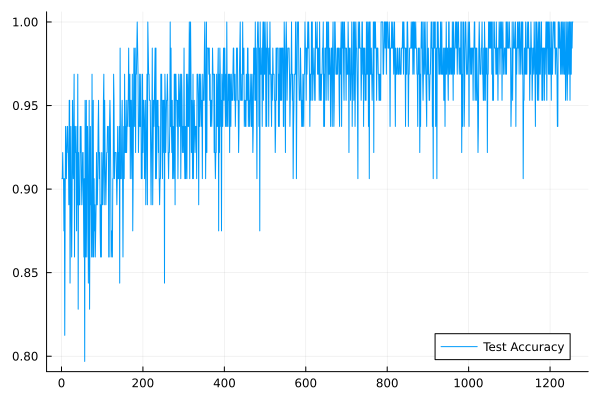

In [30]:
plot(vec_loss, label="Test Loss")
plot(vec_acc, label="Test Accuracy")

Let's make some predictions

In [31]:
idx = rand(1:1000, 16)
xs = test_loader.data[idx][1]
yp = xs |> model |> softmax |> out -> onecold(out, 0:9) |> cpu
ys = onecold(test_loader.data[idx][2]) .- 1 |> cpu;

In [32]:
for i ∈ eachindex(yp)
    @info "**Prediction is $(yp[i]). Label is $(ys[i]).**"
end

[ Info: **Prediction is 2. Label is 2.**
[ Info: **Prediction is 3. Label is 3.**
[ Info: **Prediction is 5. Label is 5.**
[ Info: **Prediction is 3. Label is 3.**
[ Info: **Prediction is 1. Label is 1.**
[ Info: **Prediction is 7. Label is 7.**
[ Info: **Prediction is 1. Label is 1.**
[ Info: **Prediction is 1. Label is 1.**
[ Info: **Prediction is 8. Label is 8.**
[ Info: **Prediction is 6. Label is 6.**
[ Info: **Prediction is 2. Label is 2.**
[ Info: **Prediction is 4. Label is 4.**
[ Info: **Prediction is 8. Label is 8.**
[ Info: **Prediction is 6. Label is 6.**
[ Info: **Prediction is 1. Label is 1.**
[ Info: **Prediction is 7. Label is 7.**


Save the model

In [27]:
#=
using BSON: @save
@save "cnn.bson" model
=#